# Mohs Hardness Regresson Competition

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e25/sample_submission.csv
/kaggle/input/playground-series-s3e25/train.csv
/kaggle/input/playground-series-s3e25/test.csv


In [2]:
# Additional Imports
import math
import joblib
from scipy import stats

# Scikit learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, KFold, cross_val_score, cross_val_predict
from sklearn.metrics import median_absolute_error, max_error, PredictionErrorDisplay, make_scorer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor, StackingRegressor, HistGradientBoostingRegressor

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [3]:
# Data
train = pd.read_csv("/kaggle/input/playground-series-s3e25/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s3e25/test.csv")

In [4]:
# Check
train.head(3)

,id,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
0,0,100.0,0.841611,10.0,4.8,20.612526,11.08810,2.766,1.732,0.860,0.496070,0.91457,6.0
1,1,100.0,7.558488,10.0,4.8,20.298893,12.04083,2.755,1.631,0.910,0.492719,0.71760,6.5
2,2,76.0,8.885992,15.6,5.6,33.739258,12.08630,2.828,1.788,0.864,0.481478,1.50633,2.5


In [5]:
# Describe
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,10407.0,5203.000000,3004.386460,0.0,2601.500000,5203.000000,7804.500000,10406.000000
allelectrons_Total,10407.0,128.053516,224.123776,0.0,68.000000,100.000000,131.000000,15300.000000
density_Total,10407.0,14.491342,15.972877,0.0,7.558488,10.650000,16.676996,643.093804
allelectrons_Average,10407.0,17.033222,10.468734,0.0,10.000000,12.600000,22.000000,67.000000
val_e_Average,10407.0,4.546789,0.690864,0.0,4.000000,4.714286,4.800000,6.000000
atomicweight_Average,10407.0,37.507703,26.012313,0.0,20.298893,26.203827,48.719500,167.400000
ionenergy_Average,10407.0,10.938308,1.408276,0.0,10.590660,11.202760,11.670725,15.245810
el_neg_chi_Average,10407.0,2.607662,0.334906,0.0,2.530000,2.706000,2.805000,3.443000
R_vdw_element_Average,10407.0,1.731330,0.192481,0.0,1.672500,1.732727,1.800000,2.250000
R_cov_element_Average,10407.0,0.944132,0.180017,0.0,0.864000,0.915556,0.981667,1.615840


## EDA

In [6]:
# Drop the id field
train.drop(['id'], axis=1, inplace=True)

# Check
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10407 entries, 0 to 10406
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   allelectrons_Total     10407 non-null  float64
 1   density_Total          10407 non-null  float64
 2   allelectrons_Average   10407 non-null  float64
 3   val_e_Average          10407 non-null  float64
 4   atomicweight_Average   10407 non-null  float64
 5   ionenergy_Average      10407 non-null  float64
 6   el_neg_chi_Average     10407 non-null  float64
 7   R_vdw_element_Average  10407 non-null  float64
 8   R_cov_element_Average  10407 non-null  float64
 9   zaratio_Average        10407 non-null  float64
 10  density_Average        10407 non-null  float64
 11  Hardness               10407 non-null  float64
dtypes: float64(12)
memory usage: 975.8 KB


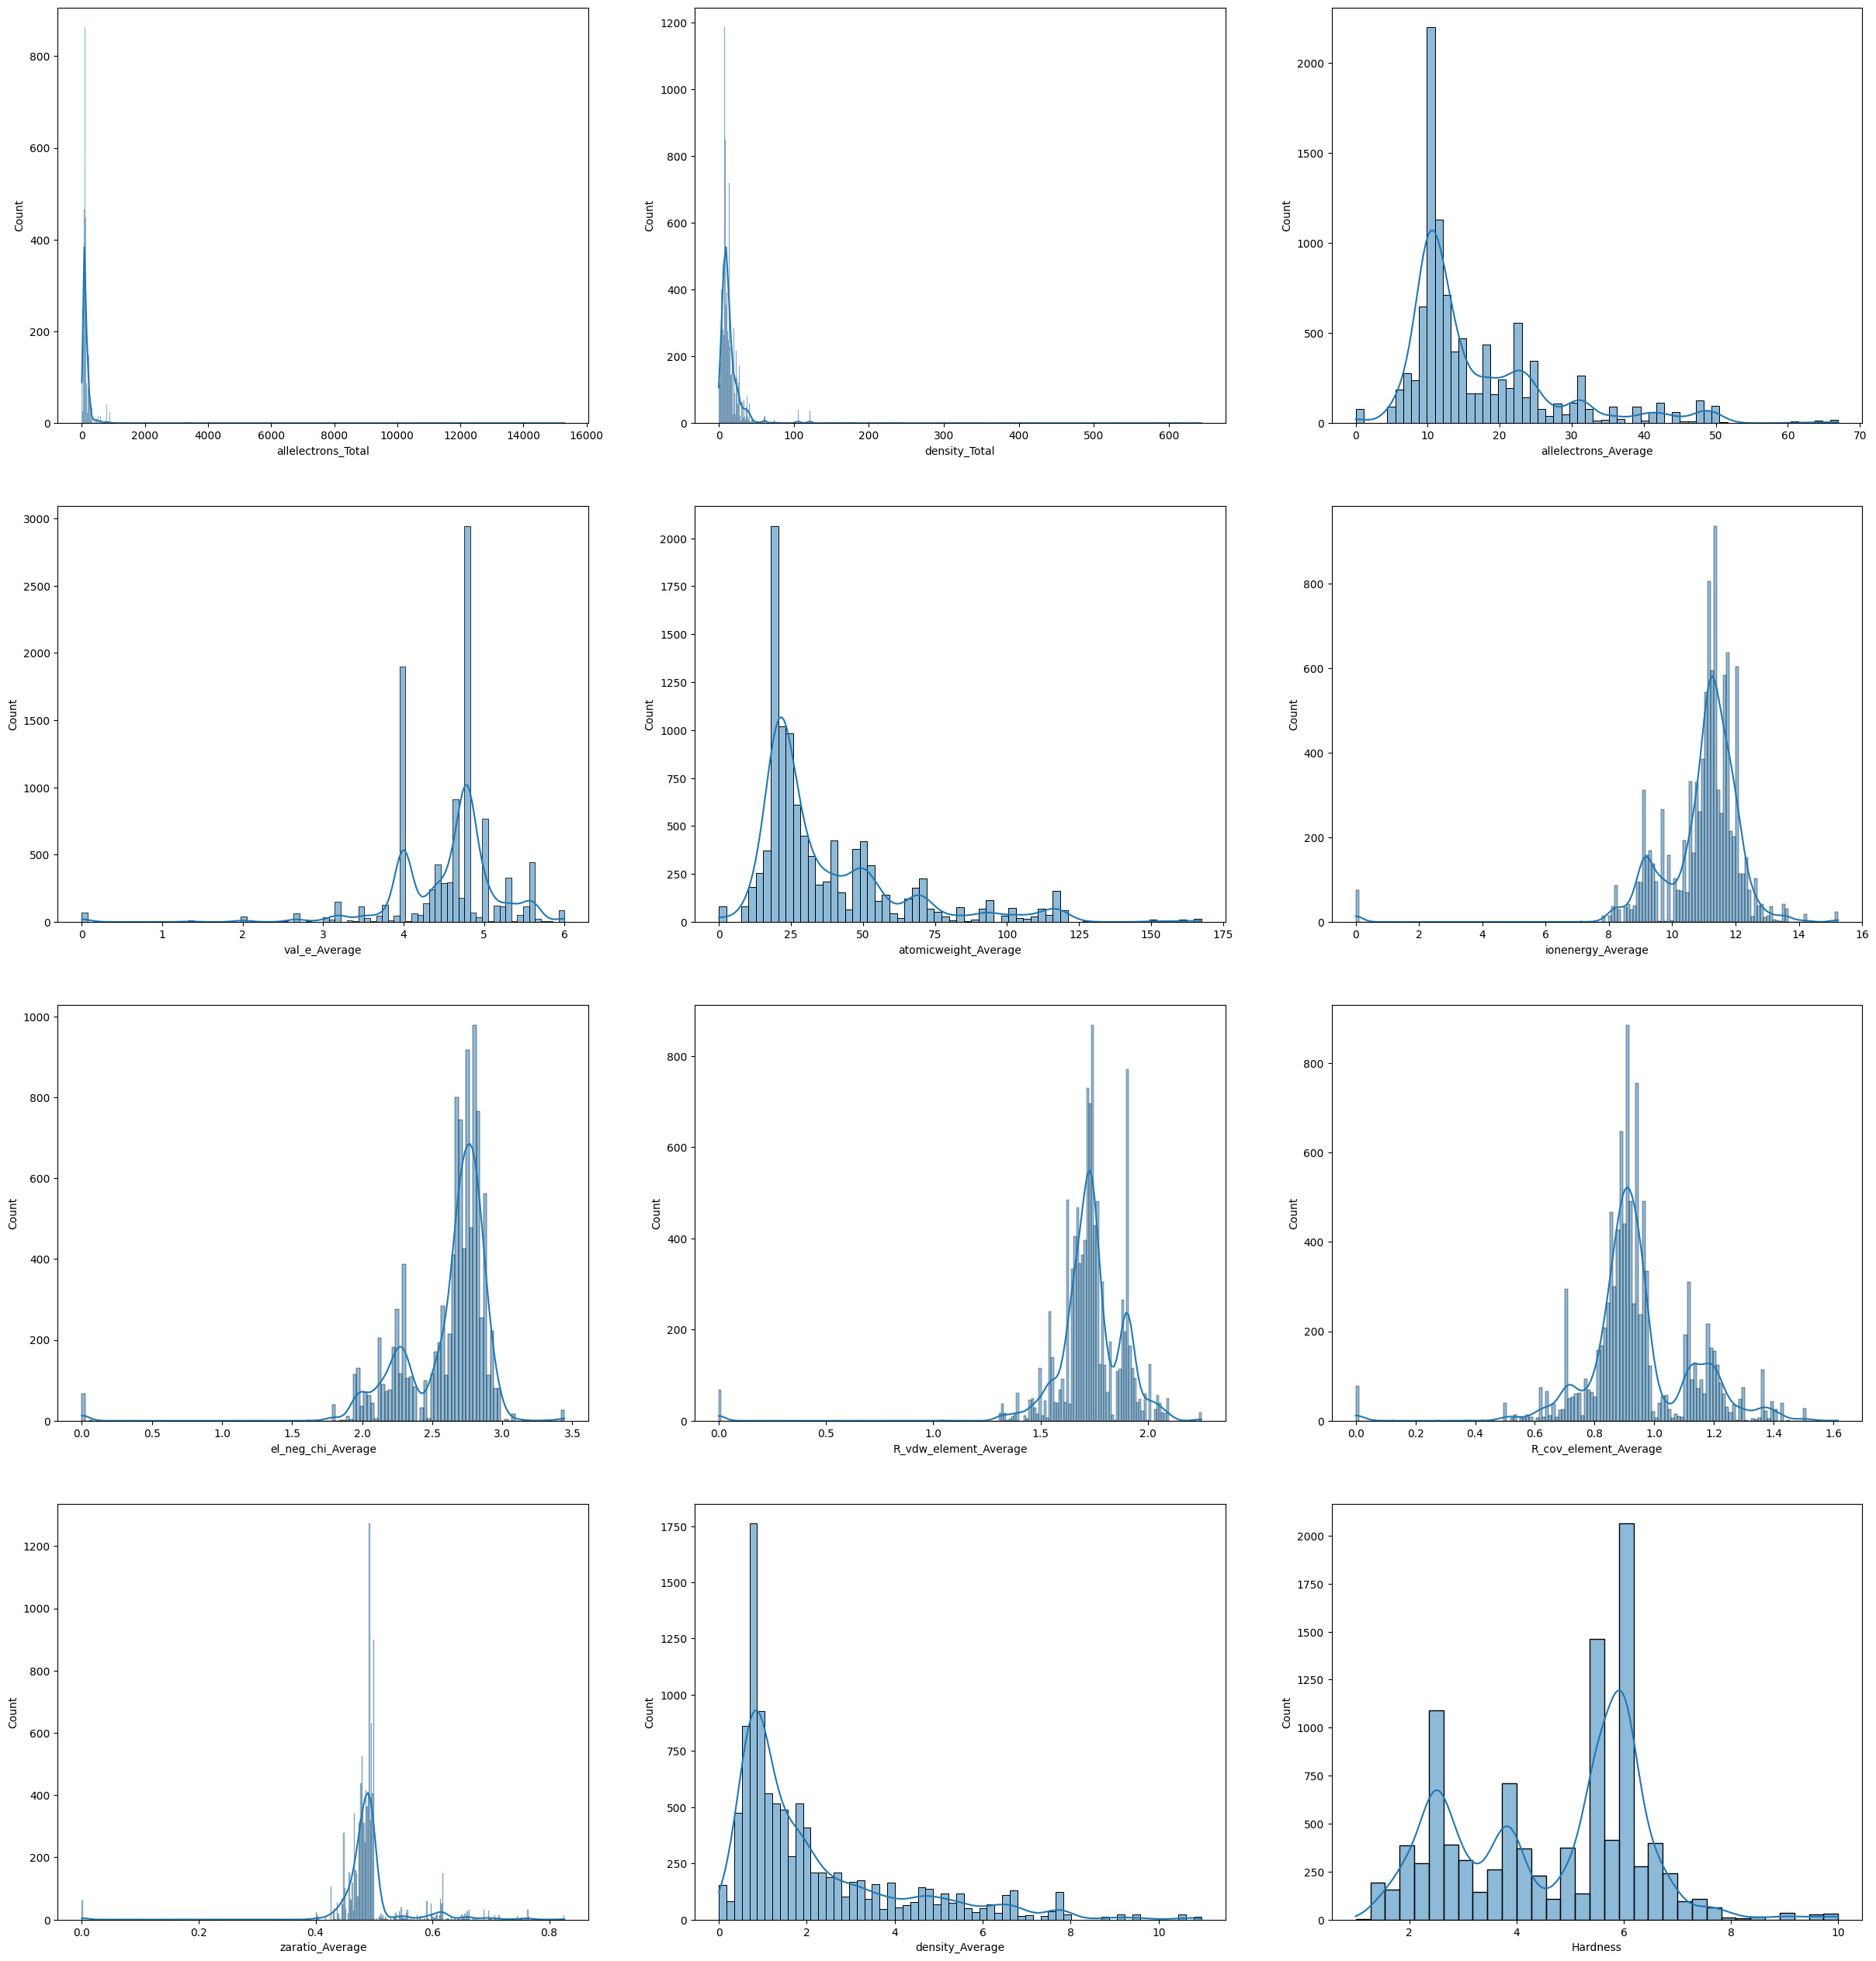

In [7]:
# Histograms
fig, axs = plt.subplots(4, 3, figsize=(30,32))

# Axes
sns.histplot(data=train, x='allelectrons_Total', kde=True, ax=axs[0, 0])

sns.histplot(data=train, x='density_Total', kde=True, ax=axs[0,1])

sns.histplot(data=train, x='allelectrons_Average', kde=True, ax=axs[0, 2])

sns.histplot(data=train, x='val_e_Average', kde=True, ax=axs[1,0])

sns.histplot(data=train, x='atomicweight_Average', kde=True, ax=axs[1, 1])

sns.histplot(data=train, x='ionenergy_Average', kde=True, ax=axs[1, 2])

sns.histplot(data=train, x='el_neg_chi_Average', kde=True, ax=axs[2, 0])

sns.histplot(data=train, x='R_vdw_element_Average', kde=True, ax=axs[2,1])

sns.histplot(data=train, x='R_cov_element_Average', kde=True, ax=axs[2,2])

sns.histplot(data=train, x='zaratio_Average', kde=True, ax=axs[3,0])

sns.histplot(data=train, x='density_Average', kde=True, ax=axs[3,1])

sns.histplot(data=train, x='Hardness', kde=True, ax=axs[3,2])

# Show
plt.show()

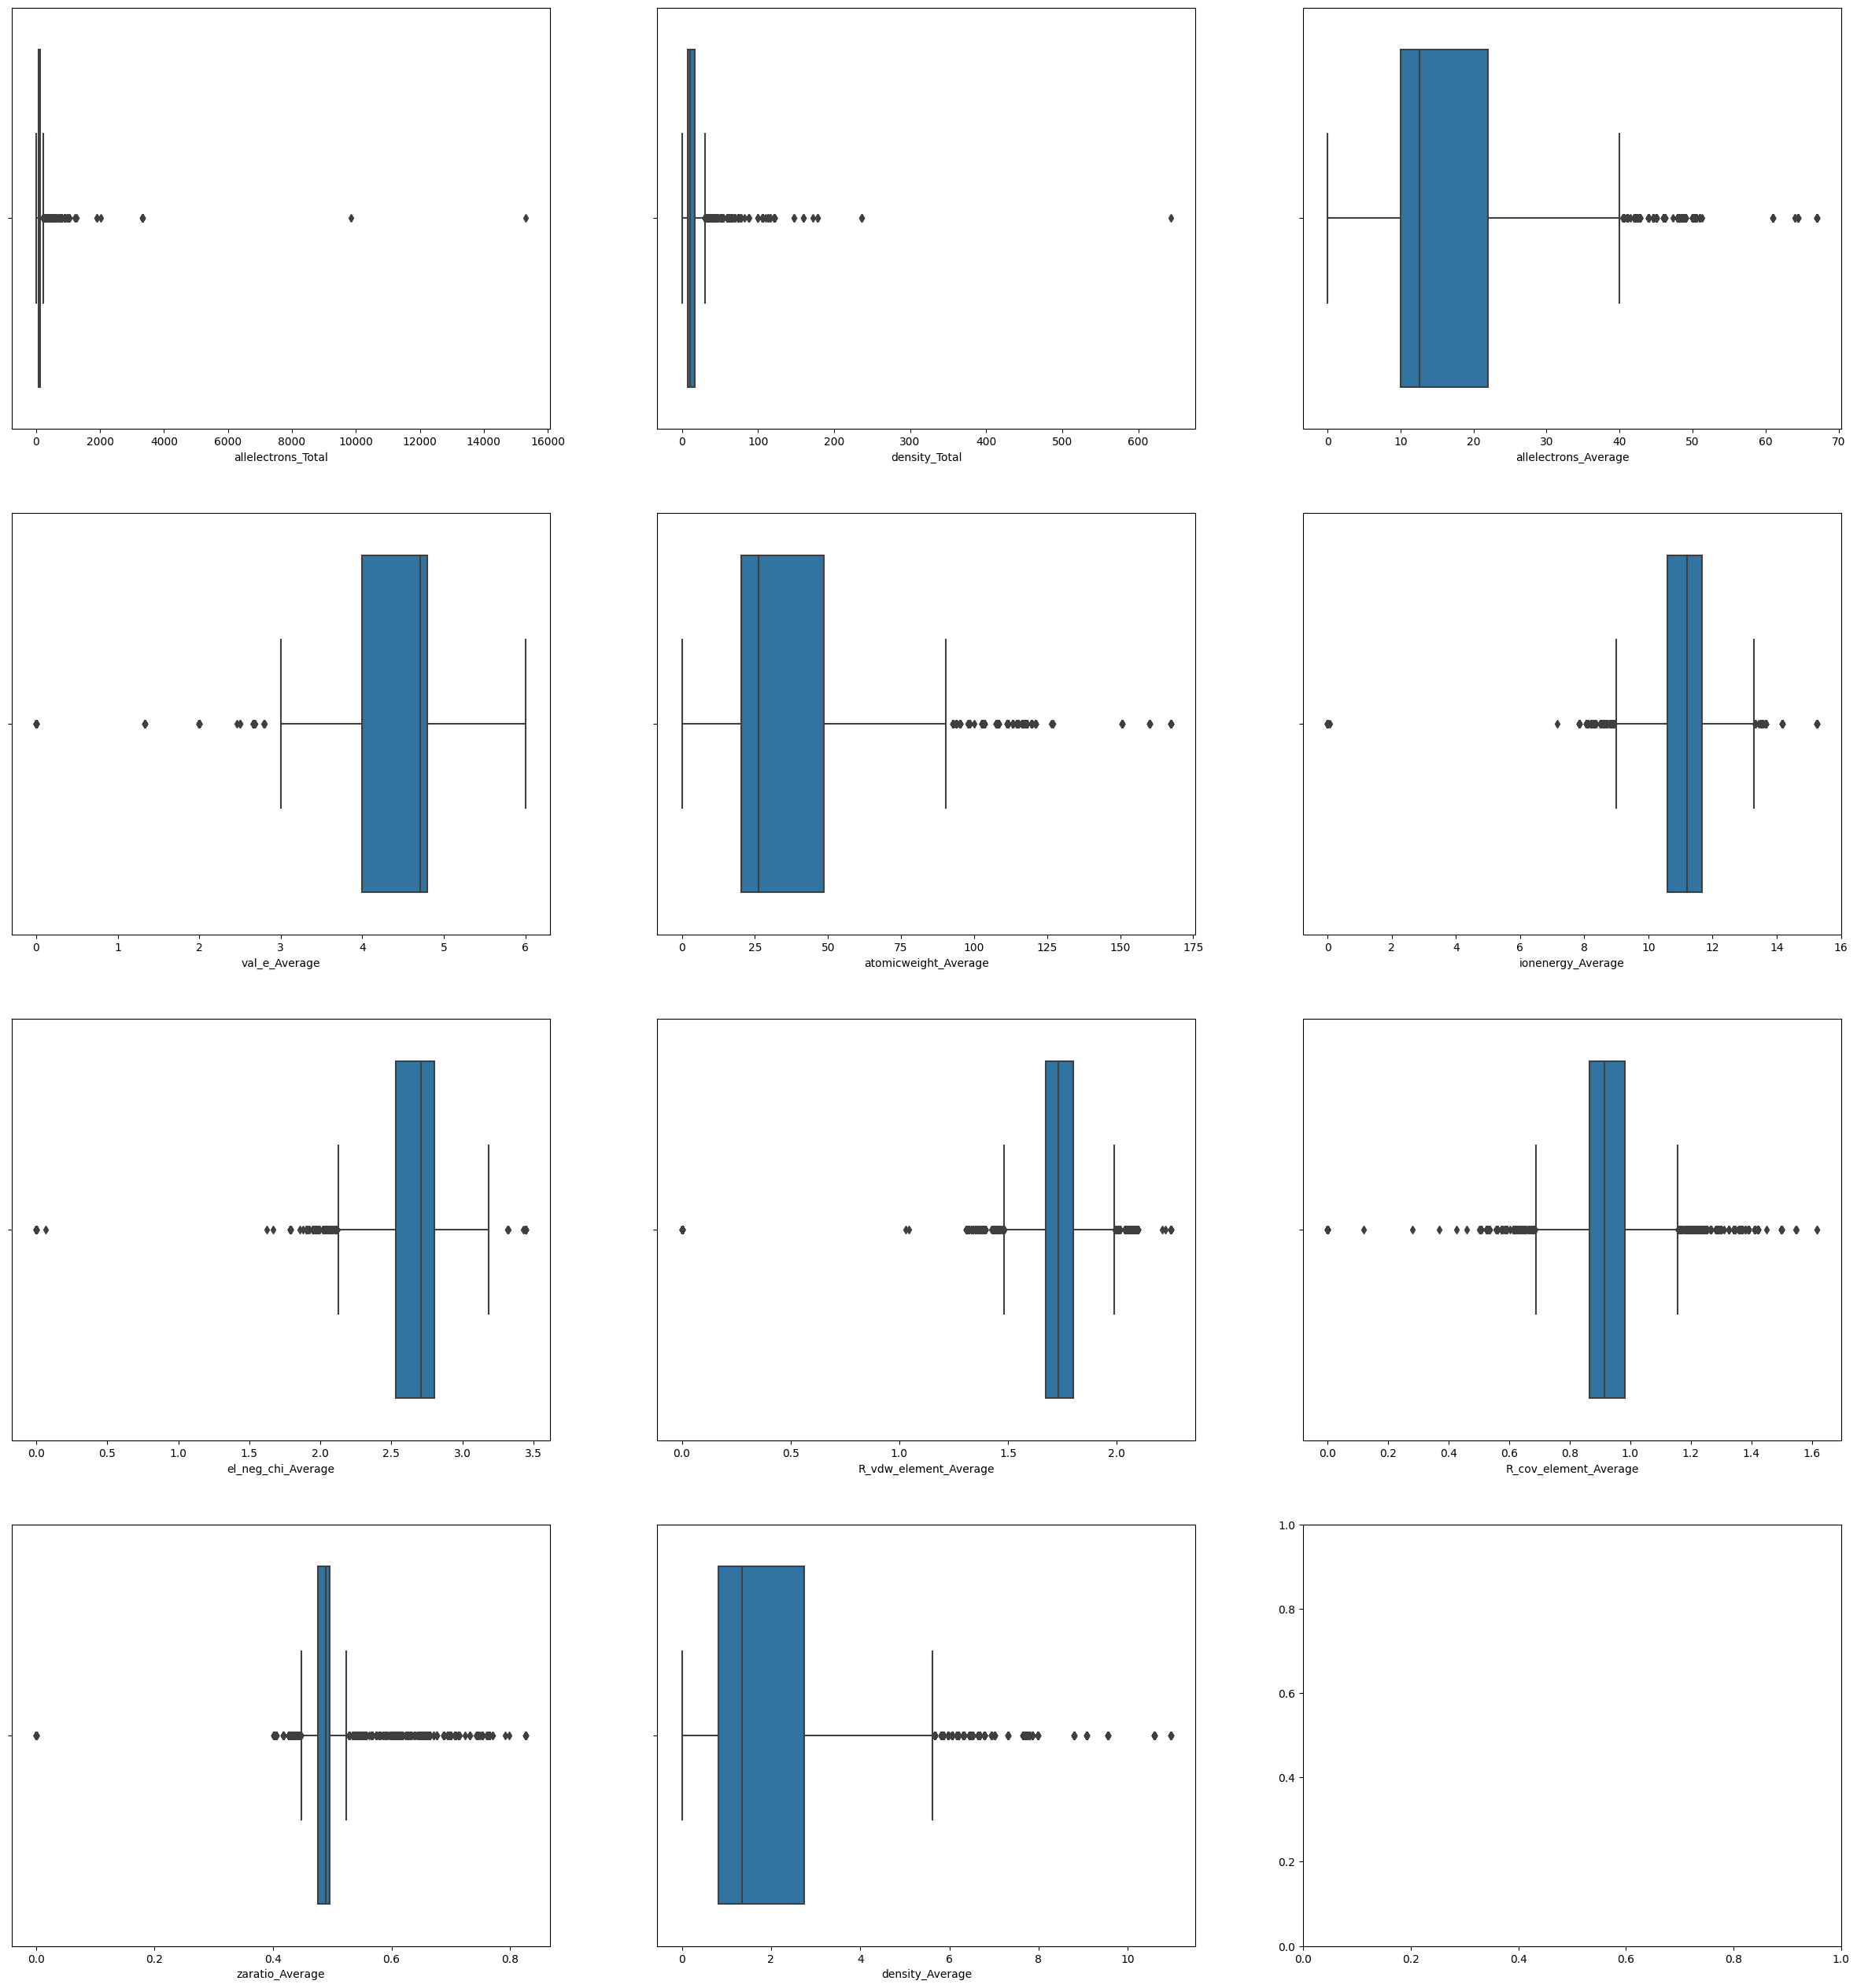

In [8]:
# Boxplots
fig, axs = plt.subplots(4, 3, figsize=(30,32))

# Axes
sns.boxplot(data=train, x='allelectrons_Total', ax=axs[0, 0])

sns.boxplot(data=train, x='density_Total', ax=axs[0,1])

sns.boxplot(data=train, x='allelectrons_Average', ax=axs[0, 2])

sns.boxplot(data=train, x='val_e_Average', ax=axs[1,0])

sns.boxplot(data=train, x='atomicweight_Average', ax=axs[1, 1])

sns.boxplot(data=train, x='ionenergy_Average', ax=axs[1, 2])

sns.boxplot(data=train, x='el_neg_chi_Average', ax=axs[2, 0])

sns.boxplot(data=train, x='R_vdw_element_Average', ax=axs[2,1])

sns.boxplot(data=train, x='R_cov_element_Average', ax=axs[2,2])

sns.boxplot(data=train, x='zaratio_Average', ax=axs[3,0])

sns.boxplot(data=train, x='density_Average', ax=axs[3,1])

# Show
plt.show()

In [9]:
# Normalize 
norm = MinMaxScaler()

In [10]:
# Fit
x_train = norm.fit_transform(train.iloc[:, :11])

In [11]:
# Isolate y
y_train = train.iloc[:,11]

In [12]:
# RepeatedKFold
cv = KFold(n_splits=10, shuffle=True, random_state=42)

## Baseline Model Performance

### KNN Regressor

In [13]:
# KNN for baseline
knn = KNeighborsRegressor(metric='manhattan')
knn_scores = cross_val_score(knn, x_train, y_train, scoring='neg_mean_absolute_error', cv=cv, error_score='raise', n_jobs=-1, verbose = 1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.3s finished


### Linear Regression

In [14]:
# Linear Regression for baseline
lr = LinearRegression()
lr_scores = cross_val_score(lr, x_train, y_train, scoring='neg_mean_absolute_error', cv=cv, error_score='raise', n_jobs=-1, verbose = 1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


### Extra Trees Regressor

In [15]:
# Baseline model
etr = ExtraTreesRegressor()
etr_scores = cross_val_score(etr, x_train, y_train, scoring='neg_mean_absolute_error', cv=cv, error_score='raise', n_jobs=-1, verbose = 1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   11.3s finished


### Scores Review

In [16]:
# Create a dataframe
cv_scores_df = pd.DataFrame({'knn_regressor': knn_scores,
                             'logistic_regression': lr_scores,
                             'extra_trees_regression': etr_scores})

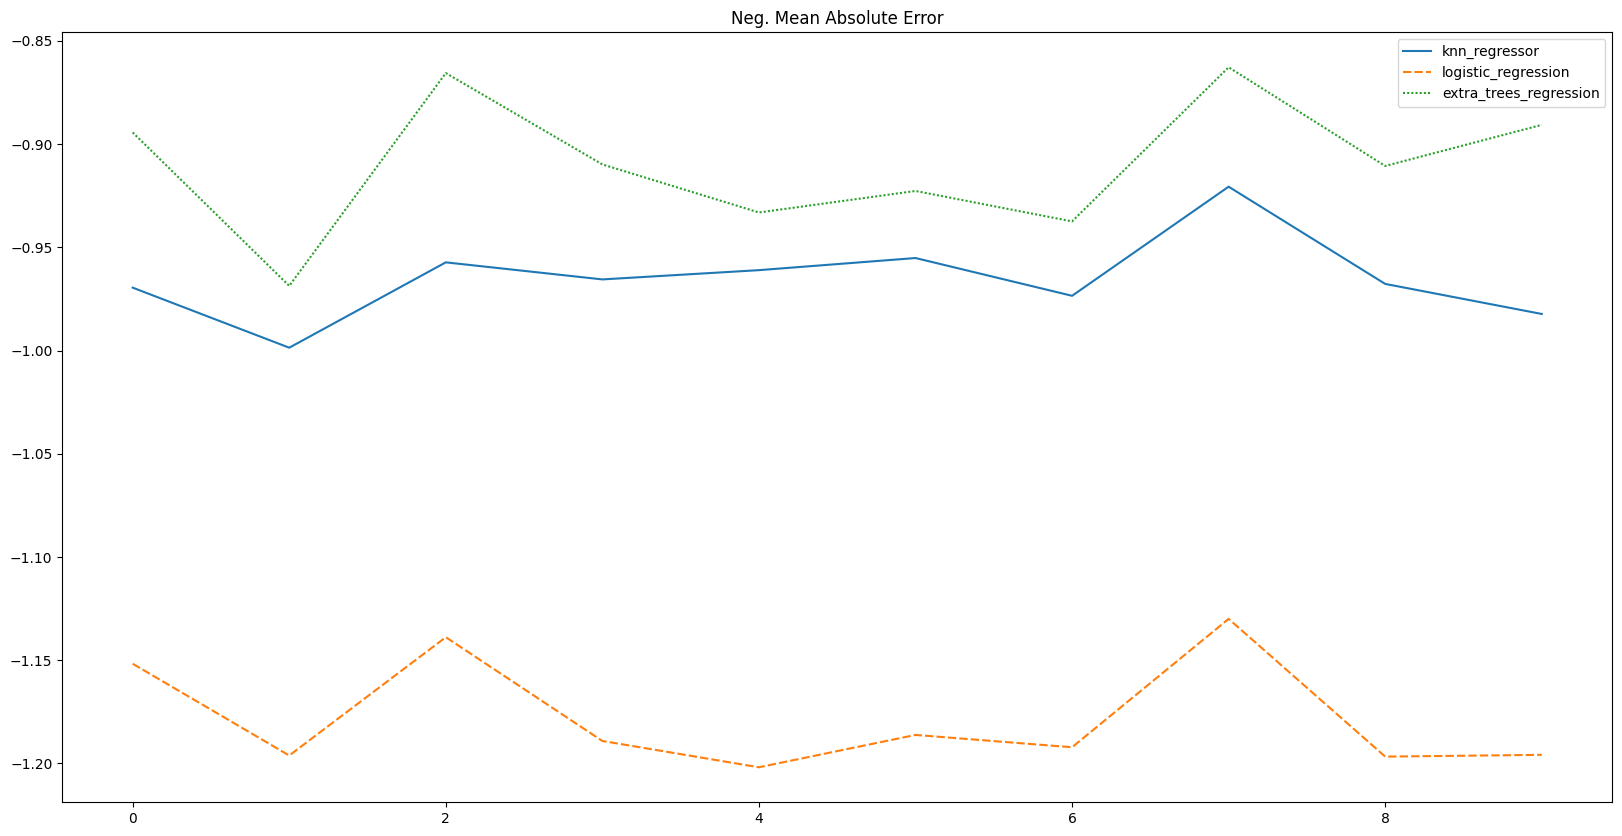

In [17]:
# Plot
plt.figure(figsize=(20, 10))

# Lineplot
sns.lineplot(data=cv_scores_df)

# Title
plt.title('Neg. Mean Absolute Error')

# Show
plt.show()

In [18]:
# Predictions
knn_preds = cross_val_predict(knn, x_train, y_train, cv=cv)
lr_preds = cross_val_predict(lr, x_train, y_train, cv=cv)
etr_preds = cross_val_predict(etr, x_train, y_train, cv=cv)

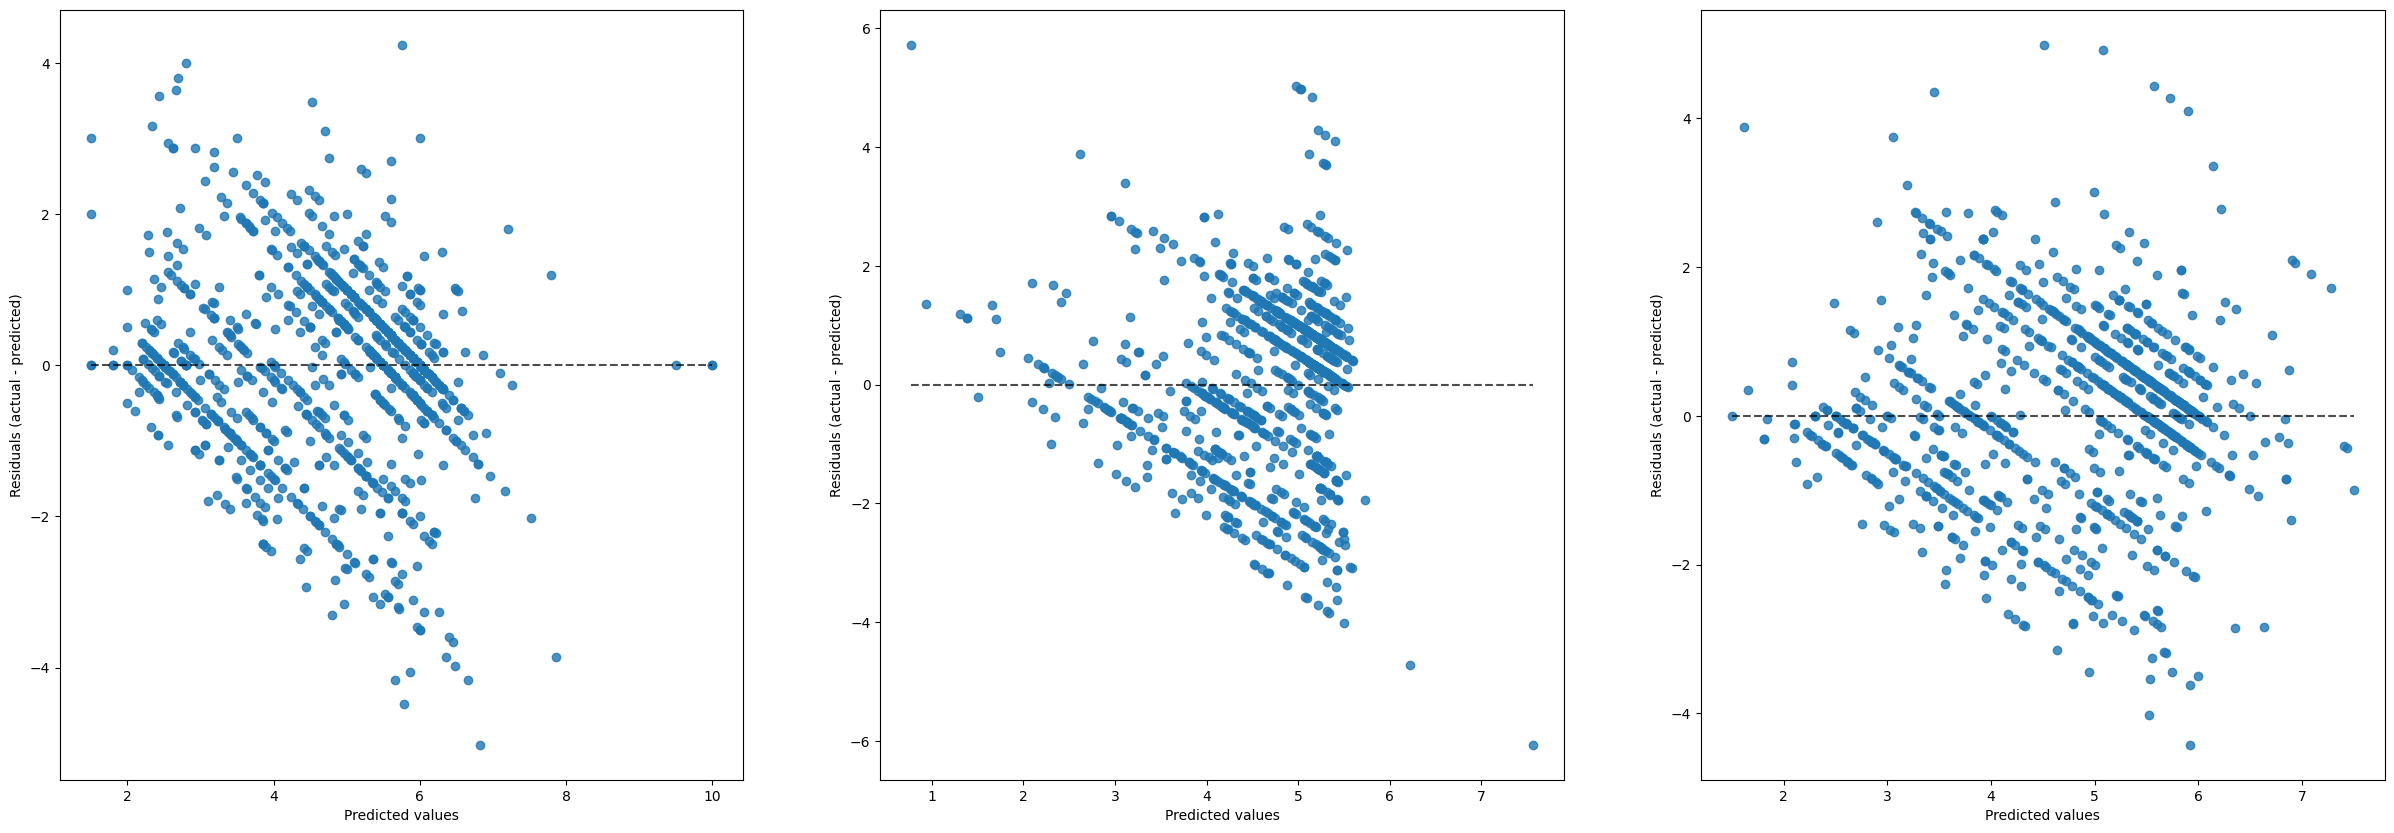

In [19]:
# Prediction Error Displays
fig, axs = plt.subplots(1,3, figsize=(30, 10))

# Axes
PredictionErrorDisplay.from_predictions(y_true=y_train, y_pred=knn_preds, kind='residual_vs_predicted', ax=axs[0])
PredictionErrorDisplay.from_predictions(y_true=y_train, y_pred=lr_preds, kind='residual_vs_predicted', ax=axs[1])
PredictionErrorDisplay.from_predictions(y_true=y_train, y_pred=etr_preds, kind='residual_vs_predicted', ax=axs[2])

# Show
plt.show()

## Build a Model

- Use HalvingGridSearchCV to identify the models and their parameters that do the best in predicting.

In [20]:
# Models
MODELS = [('knn', KNeighborsRegressor(metric='manhattan')),
          ('linreg', LinearRegression()),
          ('extra-trees', ExtraTreesRegressor(random_state=42))]

In [21]:
# Set parameters
PARAMS = {'knn__n_neighbors': [5, 10, 20],
          'extra-trees__n_estimators': [100, 300, 500],
          'extra-trees__criterion': ['squared_error', 'absolute_error'],
          'extra-trees__min_samples_split': [math.floor(train.shape[0]*0.01), math.floor(train.shape[0]*0.05)]}

In [22]:
# CV
stacker_cv = KFold(n_splits=3, shuffle=True, random_state=42)

In [23]:
# Stacking Regressor
stacker = StackingRegressor(estimators=MODELS,
                            final_estimator=HistGradientBoostingRegressor(loss='absolute_error', early_stopping=True, scoring='loss', random_state=42))

In [24]:
# Halving
halver = HalvingGridSearchCV(estimator=stacker, param_grid=PARAMS, factor=3, cv=stacker_cv, scoring=make_scorer(median_absolute_error), verbose=2)

# Fit
halver.fit(x_train, y_train)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 385
max_resources_: 10407
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 36
n_resources: 385
Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END extra-trees__criterion=squared_error, extra-trees__min_samples_split=104, extra-trees__n_estimators=100, knn__n_neighbors=5; total time=   0.7s
[CV] END extra-trees__criterion=squared_error, extra-trees__min_samples_split=104, extra-trees__n_estimators=100, knn__n_neighbors=5; total time=   0.7s
[CV] END extra-trees__criterion=squared_error, extra-trees__min_samples_split=104, extra-trees__n_estimators=100, knn__n_neighbors=5; total time=   0.7s
[CV] END extra-trees__criterion=squared_error, extra-trees__min_samples_split=104, extra-trees__n_estimators=100, knn__n_neighbors=10; total time=   0.7s
[CV] END extra-trees__criterion=squared_error, extra-trees__min_samples_split=104, extra-trees__n_estimators=100, knn__n_nei

HalvingGridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
                    estimator=StackingRegressor(estimators=[('knn',
                                                             KNeighborsRegressor(metric='manhattan')),
                                                            ('linreg',
                                                             LinearRegression()),
                                                            ('extra-trees',
                                                             ExtraTreesRegressor(random_state=42))],
                                                final_estimator=HistGradientBoostingRegressor(early_stopping=True,
                                                                                              loss='absolute_error',
                                                                                              random_state=42)),
                    param_grid={'extra-trees__criterion': ['squared_error',
                                                           'absolute_error'],
                                'extra-trees__min_samples_split': [104, 520],
                                'extra-trees__n_estimators': [100, 300, 500],
                                'knn__n_neighbors': [5, 10, 20]},
                    scoring=make_scorer(median_absolute_error), verbose=2)

In [25]:
# Send performance to dataframe
halver_df = pd.DataFrame(halver.cv_results_)

# Show
display(halver_df)

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_extra-trees__criterion,param_extra-trees__min_samples_split,param_extra-trees__n_estimators,param_knn__n_neighbors,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0,385,0.692271,0.005470,0.008832,0.000205,squared_error,104,100,5,...,0.861237,0.870789,0.738632,0.180186,34,0.493345,0.496501,0.811208,0.600351,0.149104
1,0,385,0.698764,0.037333,0.009161,0.000423,squared_error,104,100,10,...,0.926825,0.914747,0.805943,0.162487,5,0.547038,0.546252,0.839703,0.644331,0.138150
2,0,385,0.722731,0.023305,0.009371,0.000197,squared_error,104,100,20,...,0.849347,0.831222,0.771652,0.097343,21,0.498120,0.475958,0.871944,0.615341,0.181671
3,0,385,2.011431,0.142142,0.278375,0.369318,squared_error,104,300,5,...,0.956489,0.966685,0.831039,0.184671,2,0.500732,0.499261,0.774405,0.591466,0.129359
4,0,385,1.905681,0.033248,0.018204,0.000459,squared_error,104,300,10,...,0.877848,0.853423,0.765549,0.141895,22,0.529198,0.545597,0.789546,0.621447,0.119052
5,0,385,1.913909,0.056861,0.017701,0.000732,squared_error,104,300,20,...,0.903403,0.890271,0.797898,0.140024,7,0.500067,0.559688,0.848251,0.636002,0.152044
6,0,385,3.084904,0.047289,0.025159,0.000224,squared_error,104,500,5,...,0.934984,1.014107,0.859845,0.165396,1,0.540243,0.501992,0.835940,0.626058,0.149228
7,0,385,3.057353,0.028705,0.024874,0.000512,squared_error,104,500,10,...,0.871973,0.910345,0.776996,0.162210,20,0.552256,0.537685,0.836756,0.642232,0.137678
8,0,385,3.071058,0.077324,0.025064,0.000509,squared_error,104,500,20,...,0.900802,0.872129,0.798610,0.124797,6,0.500023,0.531862,0.827614,0.619833,0.147497
9,0,385,0.672945,0.027506,0.008663,0.000286,squared_error,520,100,5,...,0.740242,0.913945,0.753386,0.126073,26,0.525903,0.508841,0.894417,0.643054,0.177877


In [26]:
# Find the best parameters
halver.best_params_

{'extra-trees__criterion': 'squared_error',
 'extra-trees__min_samples_split': 520,
 'extra-trees__n_estimators': 300,
 'knn__n_neighbors': 10}

## Final Model

In [27]:
# Final models
FINAL_MODELS = [('knn', KNeighborsRegressor(n_neighbors=20, metric='manhattan')),
                ('linreg', LinearRegression()),
                ('extra-trees', ExtraTreesRegressor(n_estimators=100, min_samples_split=520, criterion='squared_error', random_state=42))]

In [28]:
# Final stack
final_stacker = StackingRegressor(estimators=FINAL_MODELS,
                                  final_estimator=HistGradientBoostingRegressor(loss='absolute_error', early_stopping=True, scoring='loss', random_state=42))

# Fit
final_stacker.fit(x_train, y_train)

StackingRegressor(estimators=[('knn',
                               KNeighborsRegressor(metric='manhattan',
                                                   n_neighbors=20)),
                              ('linreg', LinearRegression()),
                              ('extra-trees',
                               ExtraTreesRegressor(min_samples_split=520,
                                                   random_state=42))],
                  final_estimator=HistGradientBoostingRegressor(early_stopping=True,
                                                                loss='absolute_error',
                                                                random_state=42))

In [29]:
# Export model using joblib
joblib.dump(final_stacker, 'final_stacker.joblib')

['final_stacker.joblib']

In [30]:
# Review test data
test.head(3)

,id,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average
0,10407,884.0,121.420000,35.36,5.28,82.561240,9.370384,2.298,1.9072,1.200,0.461899,1.79459
1,10408,90.0,9.931960,18.00,5.60,39.568056,12.086300,2.868,1.6520,0.864,0.476196,1.41194
2,10409,116.0,7.767992,11.60,4.80,23.231818,11.023840,2.644,1.7940,0.960,0.499514,0.78834


In [31]:
# Update
x_test = test.drop(['id'], axis=1)

# Normalize
x_test = norm.transform(x_test)

In [32]:
# Get predictions
predictions = final_stacker.predict(x_test)

In [33]:
# Create a dataframe
submit_df = pd.DataFrame(data={'id': test['id'], 'Hardness': predictions})

# To CSV
submit_df.to_csv('results.csv', index=False)